In [ ]:
#we need add here a lot of comments

In [1]:
# Comment: Import everything we need for this test notebook.
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from data_loading.gather_mat_files_multiple import gather_mat_files_multiple_condition
from data_loading.load_intervals import load_intervals_data
from data_loading.load_scores import load_scores_data
from data_loading.load_postprocessed import load_postprocessed_data

# Comment: Define the base folder that contains your multiple-condition subfolders.
base_folder = r"D:\behavior_ethogram_project_Ilya"

In [2]:
# Comment: 2) Gather .mat files for all conditions found under the base_folder
all_condition_files, condition_names = gather_mat_files_multiple_condition([base_folder])


# Comment: 3) Load postprocessed (binary) data for each condition/behavior combination.
all_flies_post, post_index_map, post_cond_names = load_postprocessed_data(
    all_condition_files,
    single=False,
    condition_names=condition_names
)
# Comment: 4) Load continuous scores data. This function normalizes each fly's data
#            by the per-file (behavior) scoreNorm. We want to preserve the raw
#            scoreNorm values as well. For that, we can store them separately
#            (the code below shows how to collect them after calling load_scores_data).
all_flies_scores, scores_index_map, scores_cond_names = load_scores_data(
    all_condition_files,
    single=False,
    condition_names=condition_names
)

In [4]:

# 5) Capture behavior names by parsing filenames for each condition
behavior_names_per_condition = []
for cond_files in all_condition_files:
    # cond_files is a list of .mat filepaths for a single condition
    names_for_this_cond = []
    for filepath in cond_files:
        base = os.path.basename(filepath)            # e.g. "scores_Grooming.mat"
        no_ext = os.path.splitext(base)[0]           # e.g. "scores_Grooming"
        # behavior name is everything after first underscore, or if multiple underscores, up to user logic
        # example: "scores_Grooming" => "Grooming"
        parts = no_ext.split("_", 1)  # split once on first '_'
        if len(parts) == 2:
            behavior_name = parts[1]  # e.g. "Grooming"
        else:
            behavior_name = no_ext   # fallback if unexpected format
        names_for_this_cond.append(behavior_name)
    behavior_names_per_condition.append(names_for_this_cond)
    #creating dict
    export_data = {
    "postprocessed_data": all_flies_post,        # global list of postprocessed (T,B) arrays
    "index_map": post_index_map,
    "condition_names": post_cond_names,
    "behavior_names_per_condition": behavior_names_per_condition
}

In [6]:
# Comment: Create experiment datasets for each condition
exp_females_grouped = export_data['postprocessed_data'][0]
exp_females_singles = export_data['postprocessed_data'][1]
exp_males_grouped = export_data['postprocessed_data'][2]
exp_males_single = export_data['postprocessed_data'][3]

In [12]:
print(exp_females_grouped)
print(behavior_names_per_condition)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk'], ['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk'], ['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk'], ['Grooming', 'Jump', 'Long_Distance_Approach', 'Long_Lasting_Interaction', 'Short_Distance_Approach', 'Social_Clustering', 'Stable_Interaction', 'Stop', 'Touch', 'Turn', 'Walk']]


In [14]:
# Map flies to their correct condition
dfs_females_grouped = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 0  # 0 corresponds to 'Assa_Females_Grouped'
]

dfs_females_singles = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 1  # 1 corresponds to 'Assa_Females_Singles'
]

dfs_males_grouped = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 2  # 2 corresponds to 'Assa_Males_Grouped'
]

dfs_males_single = [
    pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
    for global_fly_idx, (condition_idx, local_fly_idx) in post_index_map.items()
    if condition_idx == 3  # 3 corresponds to 'Assa_Males_Single'
]


<Axes: >

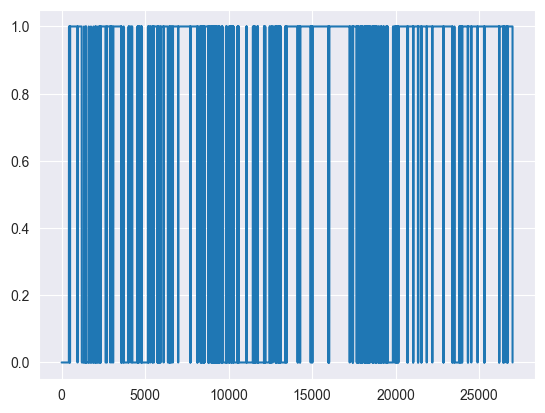

In [15]:
dfs_females_grouped[0]['Grooming'].plot()

In [16]:
# Function to create DataFrames for each condition
def create_experiment_data(condition_idx):
    return [
        pd.DataFrame(all_flies_post[global_fly_idx], columns=behavior_names_per_condition[condition_idx])
        for global_fly_idx, (cond_idx, local_fly_idx) in post_index_map.items()
        if cond_idx == condition_idx
    ]

In [58]:
import matplotlib.ticker as ticker
import matplotlib as mpl

def process_and_plot(exp_data, title):
    exp_sum = pd.DataFrame(np.sum(exp_data, axis=0), columns=behavior_names_per_condition[0]).rename_axis('time')
    exp_sum.index = exp_sum.index / 30  # Convert frames to seconds

    num_behaviors = exp_sum.shape[1]  # Actual number of behaviors
    num_cols = 3
    num_rows = int(np.ceil(num_behaviors / num_cols))  # Adjust rows dynamically

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10), sharex=True)
    axes = axes.flatten()  # Flatten to easily index

    # Use Matplotlib's default color cycle
    prop_cycle = mpl.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']  # Get default colors

    for i, col in enumerate(exp_sum.columns):
        ax = axes[i]
        exp_sum[col].plot(ax=ax, title=col, color=colors[i % len(colors)])  # Cycle through default colors

        # Dynamically adjust x-axis ticks to show minutes correctly
        max_time = exp_sum.index.max()
        tick_positions = np.linspace(0, max_time, num=4)  # 0, 5, 10, 15 min
        tick_labels = [f"{int(x/60)}" for x in tick_positions]  # Convert seconds to minutes

        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.set_xlabel("Minutes")

        ax.grid()

    # Hide any extra empty subplots
    for j in range(num_behaviors, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

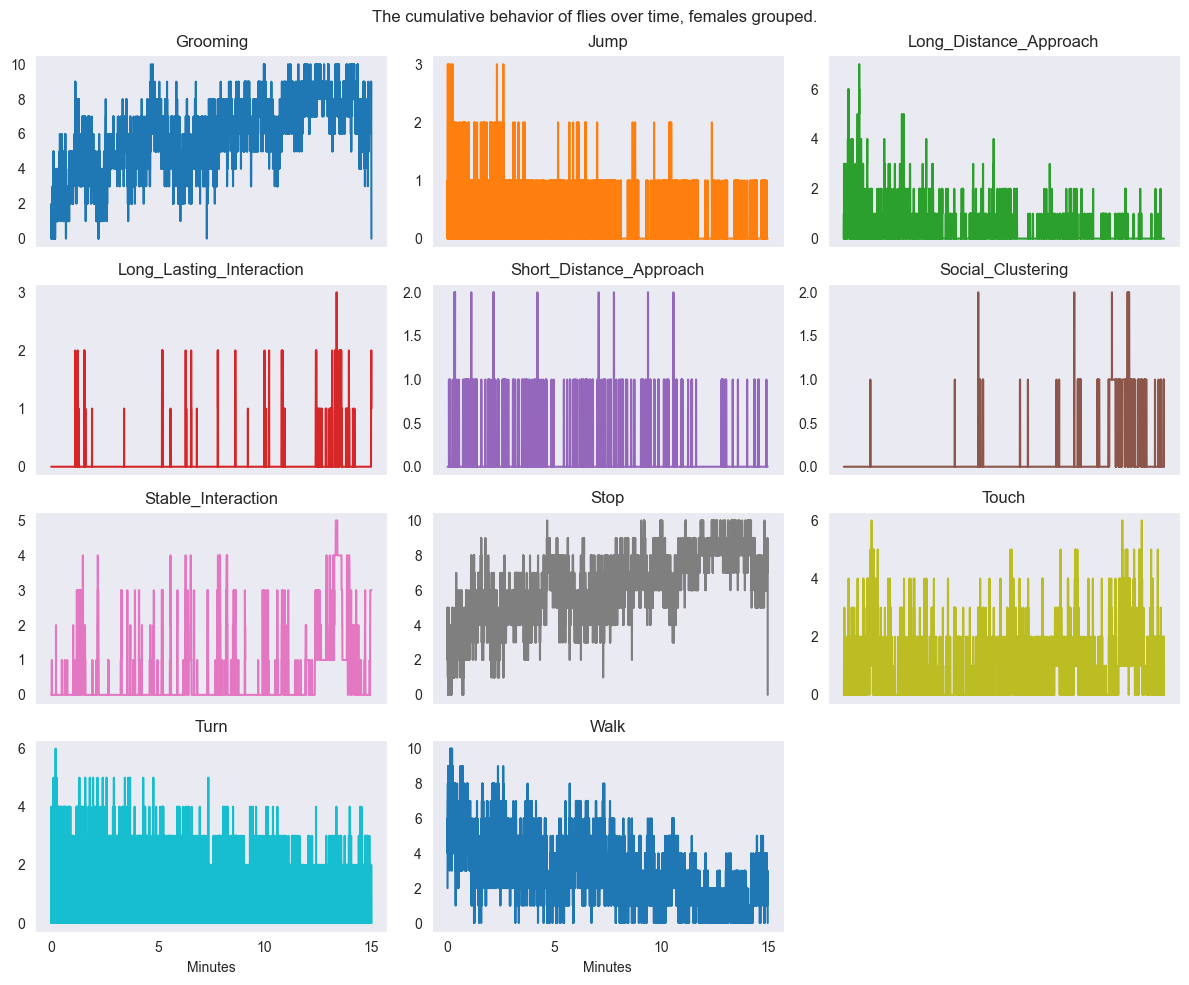

In [59]:
# Plot for experiment 1
process_and_plot(dfs_females_grouped, 'The cumulative behavior of flies over time, females grouped.')

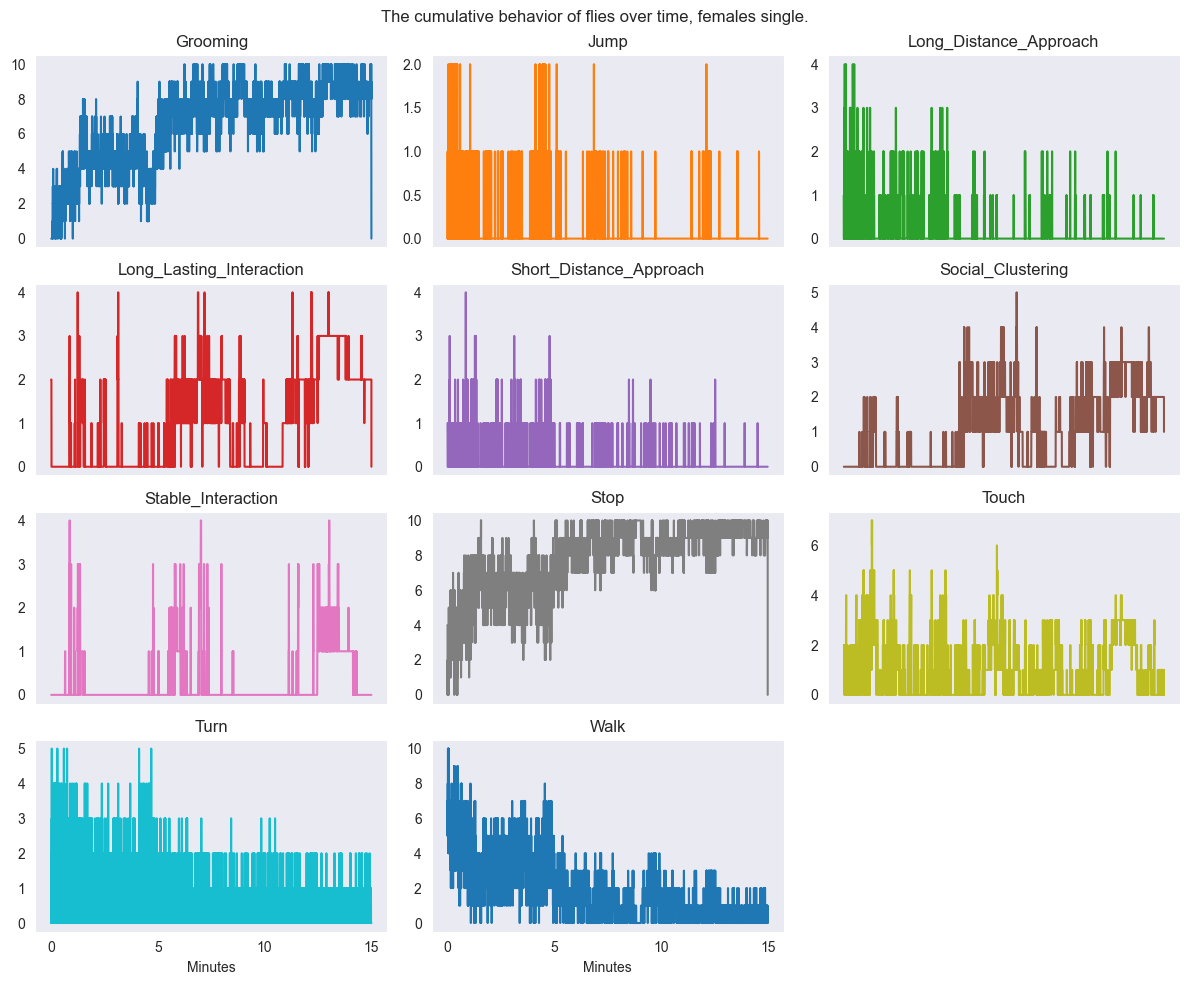

In [60]:
# Plot for experiment 2
process_and_plot(dfs_females_singles, 'The cumulative behavior of flies over time, females single.')


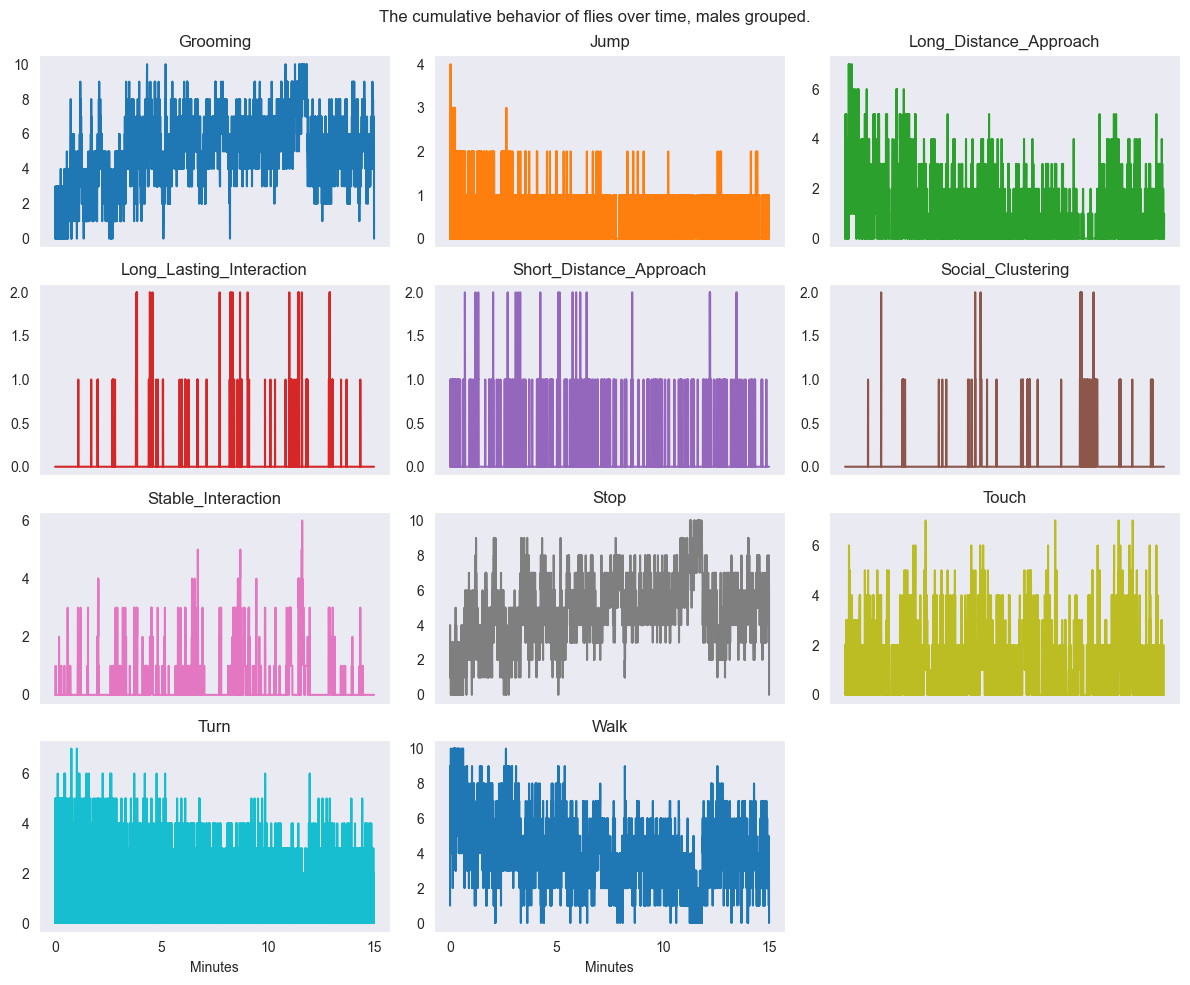

In [61]:

# Plot for experiment 3
process_and_plot(dfs_males_grouped, 'The cumulative behavior of flies over time, males grouped.')


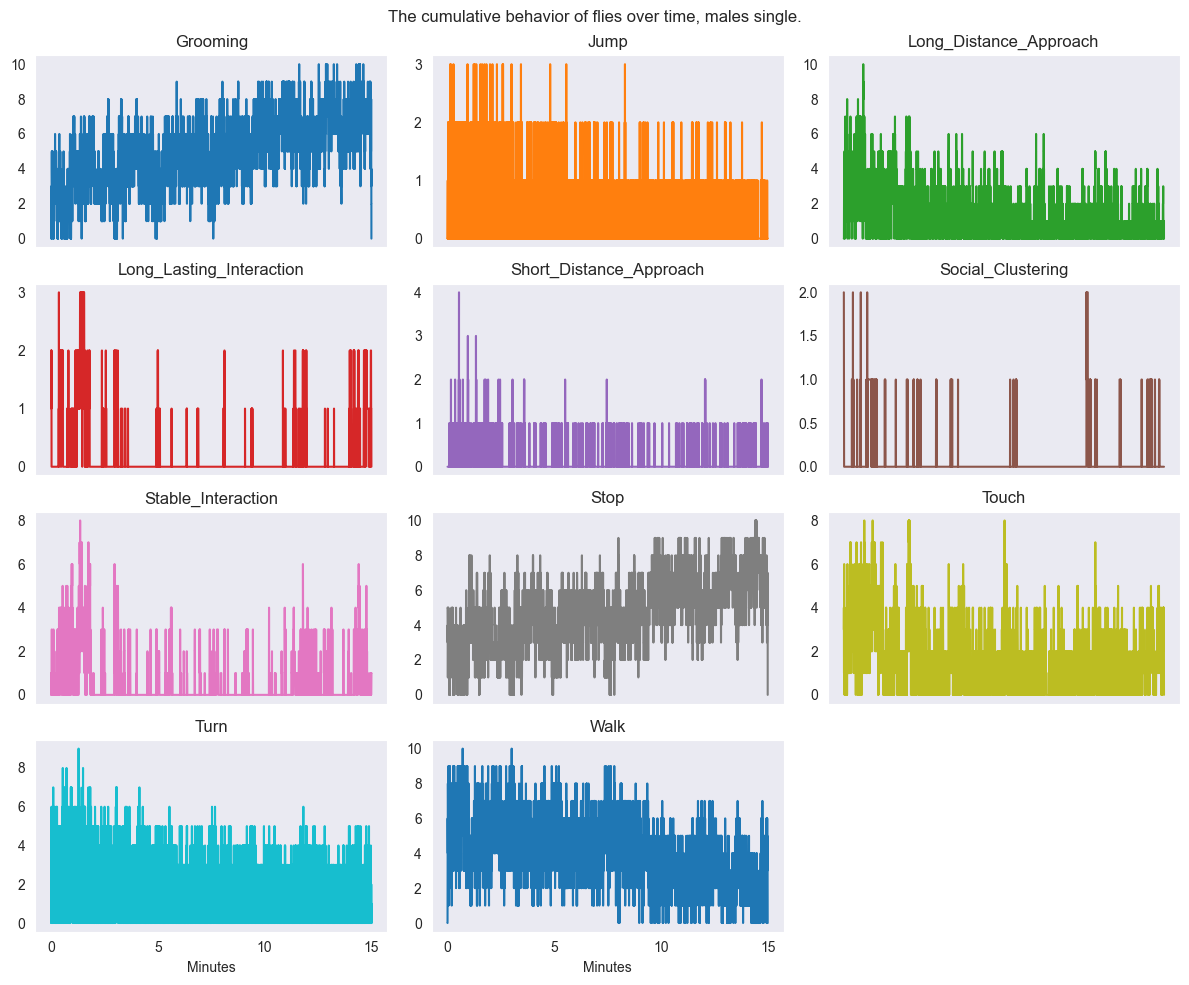

In [62]:

# Plot for experiment 4
process_and_plot(dfs_males_single, 'The cumulative behavior of flies over time, males single.')


In [63]:
def process_and_plot_grooming(exp_data, title):
    exp_sum = pd.DataFrame(np.sum(exp_data, axis=0), columns=behavior_names_per_condition[0]).rename_axis('time')
    exp_sum.index = exp_sum.index / 30  # Convert frames to seconds
    exp_grooming = exp_sum[['Grooming']]

    ax = exp_grooming.plot(figsize=(10, 6), title=title)

    # Correcting x-axis labels
    max_time = exp_grooming.index.max()
    tick_positions = np.linspace(0, max_time, num=4)  # 0, 5, 10, 15 min
    tick_labels = [f"{int(x/60)}" for x in tick_positions]  # Convert seconds to minutes

    plt.xticks(tick_positions, tick_labels)
    plt.xlabel("Time (minutes)")
    plt.ylabel("Cumulative Grooming Behavior")
    plt.grid()
    plt.show()


<Figure size 1200x800 with 0 Axes>

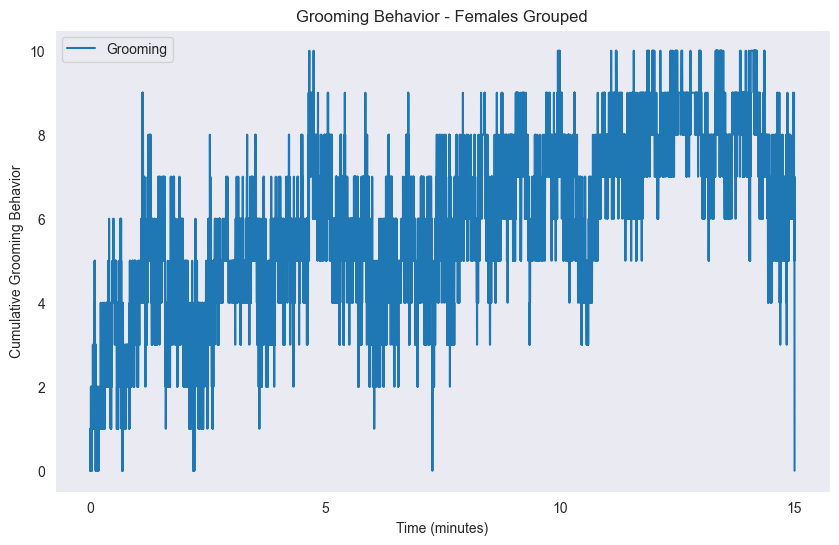

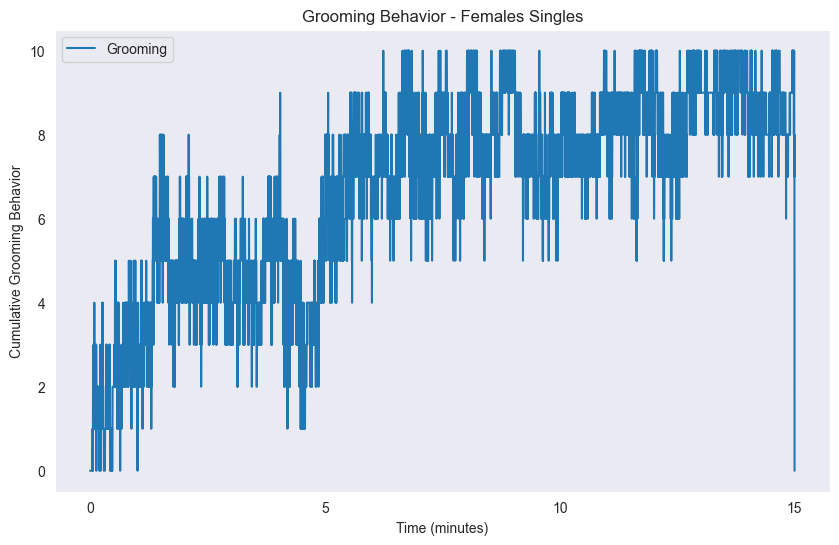

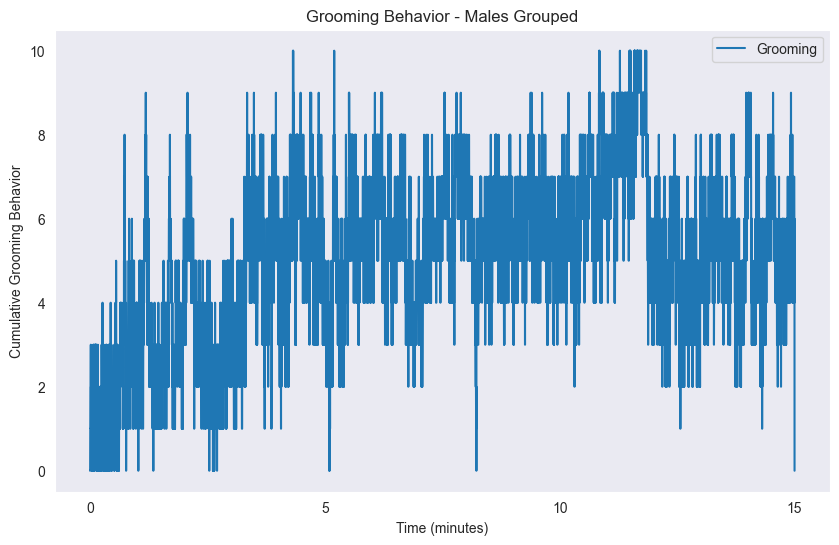

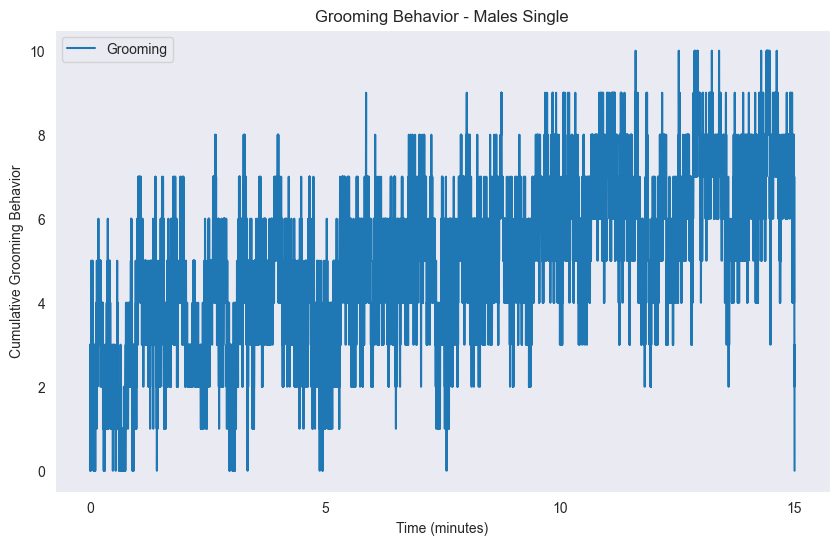

In [64]:
plt.figure(figsize=(12, 8))

process_and_plot_grooming(dfs_females_grouped, 'Grooming Behavior - Females Grouped')
process_and_plot_grooming(dfs_females_singles, 'Grooming Behavior - Females Singles')
process_and_plot_grooming(dfs_males_grouped, 'Grooming Behavior - Males Grouped')
process_and_plot_grooming(dfs_males_single, 'Grooming Behavior - Males Single')

plt.show()


In [65]:
def process_and_plot_smoothed(exp_data, title, window=30):
    exp_sum = pd.DataFrame(np.sum(exp_data, axis=0), columns=behavior_names_per_condition[0]).rename_axis('time')
    exp_sum.index = exp_sum.index / 60  # Convert frames to seconds
    exp_sum = exp_sum.rolling(window=window, min_periods=1).mean()  # Apply smoothing

    ax = exp_sum.plot(subplots=True, layout=(4, 3), figsize=(12, 10), sharex=True, title=title)

    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(300))  # Every 5 minutes
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x/60)} min"))

    plt.xlabel("Time (minutes)")
    plt.tight_layout()
    plt.show()


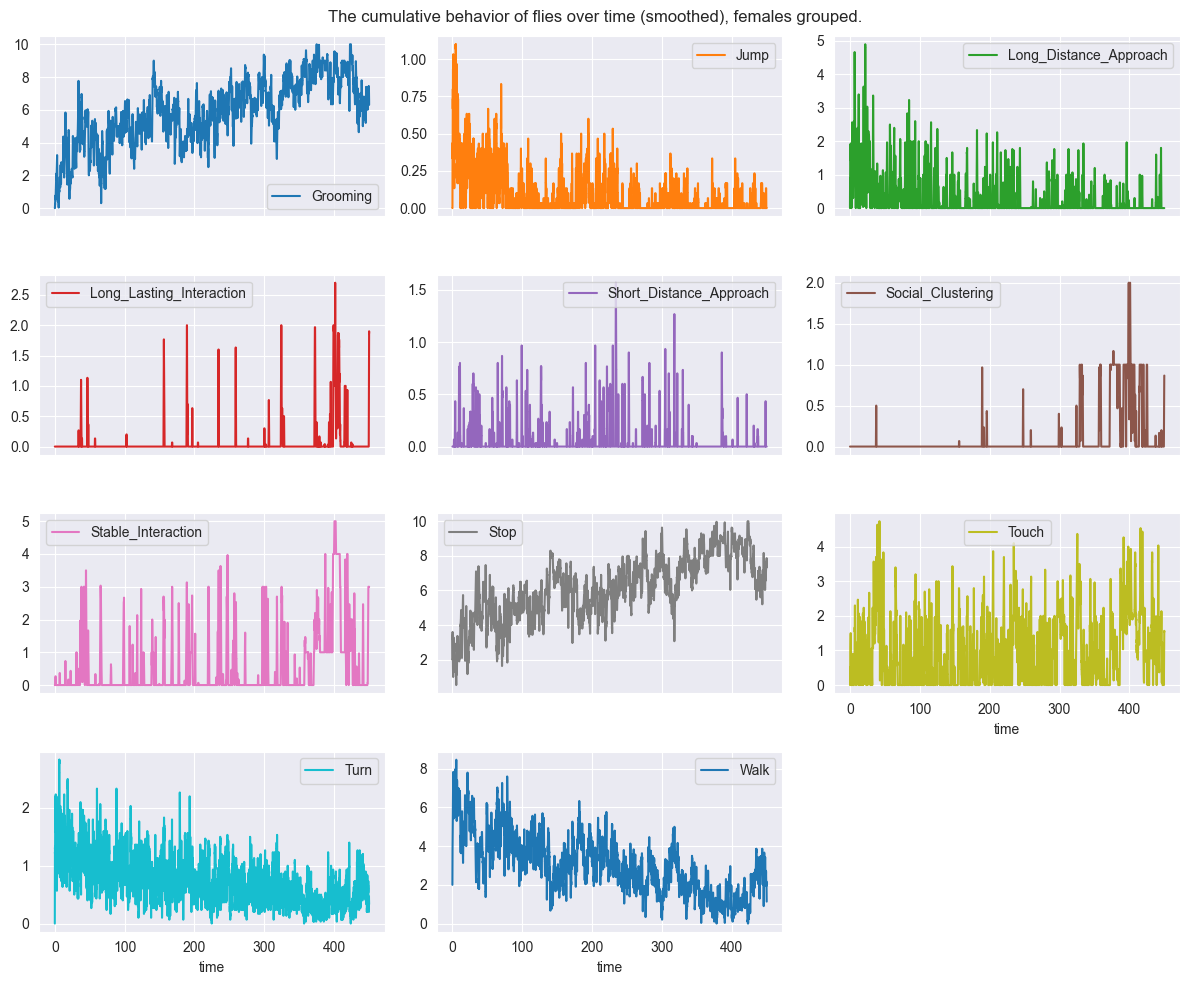

In [66]:
# Plot for experiment 1
process_and_plot_smoothed(dfs_females_grouped, 'The cumulative behavior of flies over time (smoothed), females grouped.')

In [68]:
# Combine all four experiments into a single dataset
all_exp_data = pd.concat([
    pd.DataFrame(np.sum(dfs_females_grouped, axis=0), columns=behavior_names_per_condition[0]),
    pd.DataFrame(np.sum(dfs_females_singles, axis=0), columns=behavior_names_per_condition[1]),
    pd.DataFrame(np.sum(dfs_males_grouped, axis=0), columns=behavior_names_per_condition[2]),
    pd.DataFrame(np.sum(dfs_males_single, axis=0), columns=behavior_names_per_condition[3])
], axis=0).rename_axis('time')

all_exp_data.index = all_exp_data.index / 30  # Convert frames to seconds

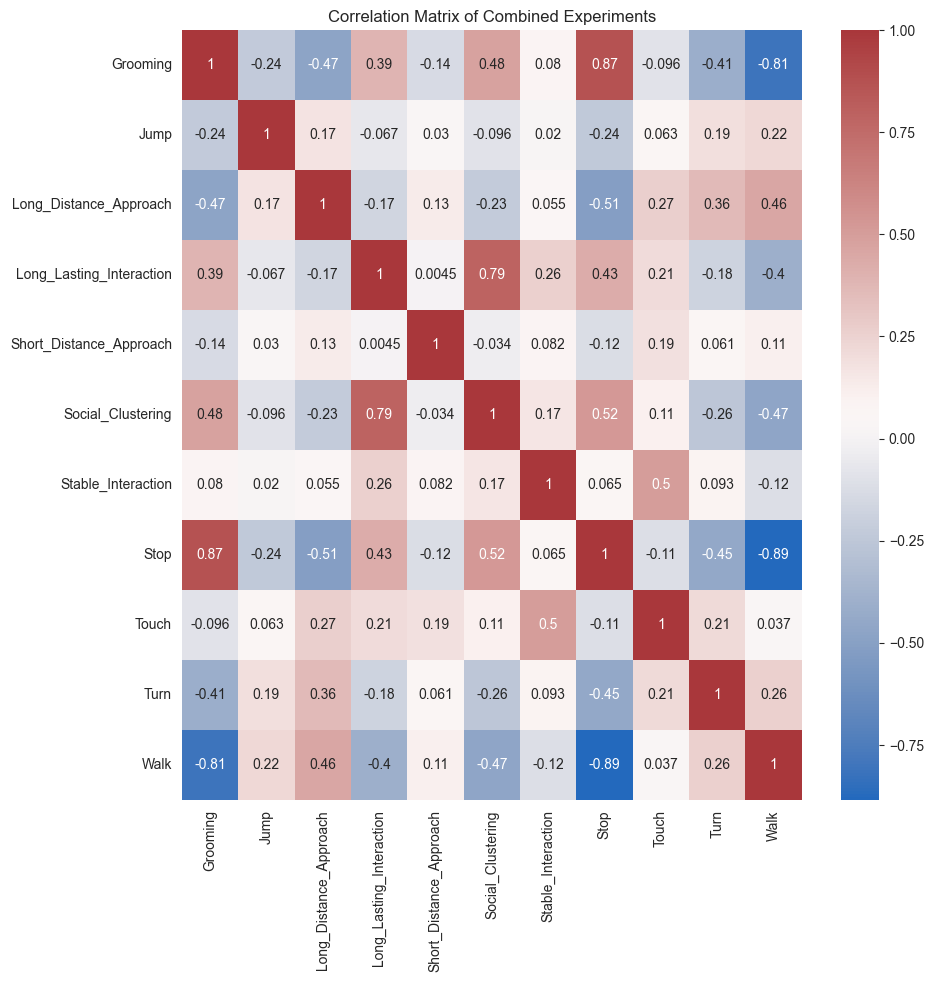

In [69]:
# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(all_exp_data.corr("pearson"), annot=True, cmap=cmap)
plt.title("Correlation Matrix of Combined Experiments")
plt.show()


In [ ]:
#Distance analysis